In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
from dsn.util.systems import system_from_str
from dsn.train_dsn import train_dsn
import seaborn as sns
import pandas as pd
import warnings
import scipy
from dsn.util import fct_mf as mf
warnings.filterwarnings("ignore")

In [2]:
def compute_mu(Sini, ics_0):
    ### Set parameters

    Mm = 3.5      # Mean of m
    Mn = 1.       # Mean of n
    Mi = 0.       # Mean of I

    Sim = 1.      # Std of m
    Sin = 1.      # Std of n
    Sip = 1.      # Std of input orthogonal to m and n, along h (see Methods)

    g = 0.8
    tol = 1e-10;
    
    eps = 0.2;
    
    ParVec = [Mm, Mn, Mi, Sim, Sin, Sini, Sip];
    ys, count = mf.SolveStatic(ics_0, g, ParVec, eps, tol);
    
    ss = ys[-1,2];
    mu = np.array([ss]);
    return mu;


In [3]:
system_D = 4;
system_str = 'R1RNN_GNG';

behavior_str = 'gng';
T = 10;
ics_0 = np.array([1., 1., 0.], np.float64);

Sini1 = 0.0;
mu1 = compute_mu(Sini1, ics_0);
print('mu1', mu1);
Sini2 = 1.0;
mu2 = compute_mu(Sini2, ics_0);
print('mu2', mu2);

mu = np.concatenate((mu1, mu2), axis=0);

Sigma = np.array([1e-12, 0.05]);
behavior = {'mu':mu, 'Sigma':Sigma};


mu1 [4.08676578e-15]
mu2 [0.9985472]


In [4]:
# create test parameter grid
bound = 2;
start = 0.0;
stop = bound;
res = 0.25;
eps = .001;
vals = np.arange(start, stop+eps, res);
vals[0] = eps;
num_pts = vals.shape[0];

total_pts = num_pts**5;
params = np.zeros((total_pts,5));
ind = 0;
for i in range(num_pts):
    Mm = vals[i];
    for j in range(num_pts):
        Mn = vals[j];
        for k in range(num_pts):
            Sim = vals[k];
            for l in range(num_pts):
                Sin = vals[l];
                for ii in range(num_pts):
                    g = vals[ii];
                    params[ind,:] = np.array([Mm, Mn, Sim, Sin, g]);
                    ind += 1;

K = 1;
M = total_pts;
Ics_0 = np.tile(np.expand_dims(np.expand_dims(ics_0, 0), 1), [K,M,1]);

system_class = system_from_str(system_str);
system = system_class(T, Ics_0, behavior_str);

In [5]:
num_params = system.D;
K = 1;
M = total_pts;
phi = tf.placeholder(dtype=tf.float64, shape=(K, M, num_params, 1));

T_a = system.simulation_suff_stats(phi);

_phi = np.expand_dims(np.expand_dims(params, 0), 3);

(3, 2, 59049, 1)
sol shape
Tensor("stack:0", shape=(3, 2, 59049, 1), dtype=float64)
X shape
Tensor("ExpandDims_60:0", shape=(1, 59049, 2), dtype=float64)


In [6]:
_mu = system.compute_mu(behavior);
print(_mu)

[4.08676578e-15 9.98547197e-01 1.00000000e-12 1.04709650e+00]


In [7]:
with tf.Session() as sess:
    _T_a = sess.run(T_a, {phi:_phi});
print(_T_a.shape)
print(_T_a[0,:,:]);


(1, 59049, 4)
[[-4.32643930e-21  2.48096977e-07  1.87180770e-41  6.15521099e-14]
 [-6.05744754e-21  2.48096977e-07  3.66926707e-41  6.15521099e-14]
 [ 2.18675882e-21  2.48096977e-07  4.78191414e-42  6.15521099e-14]
 ...
 [ 1.48743653e-15  1.33757692e+00  2.21246743e-30  1.78911201e+00]
 [-1.22632378e-15  1.29685747e+00  1.50387002e-30  1.68183929e+00]
 [ 3.58086834e-19  1.25104354e+00  1.28226181e-37  1.56510995e+00]]


In [8]:
nsamps = _phi.shape[1];
distance = np.zeros((nsamps,));
for i in range(nsamps):
    distance[i] = np.linalg.norm(_T_a[0,i,:] - _mu);


In [9]:
print(np.sum(np.isinf(distance)))
print(np.sum(np.isnan(distance)))
print(np.min(distance));
print(np.max(distance));

0
0
0.02220958050486799
3.112718477417879


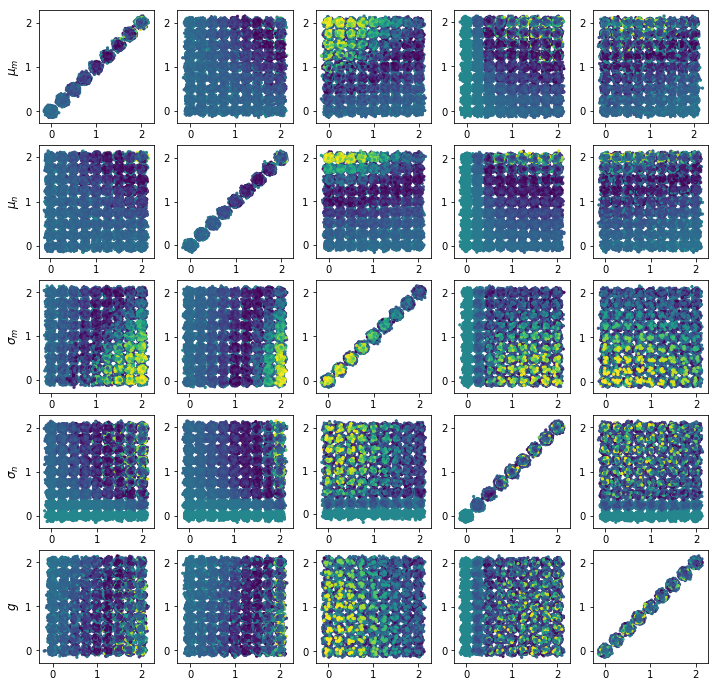

In [10]:
labels = [r'$\mu_m$', r'$\mu_n$', r'$\sigma_m$', r'$\sigma_n$', r'$g$'];

inds = np.random.permutation(nsamps);
jitter_std = 0.04;
figsize = (12,12);
fontsize = 12;
plt.figure(figsize=figsize);
for i in range(system.D):
    for j in range(system.D):
        ind = system.D*i + j + 1;
        plt.subplot(system.D, system.D, ind);
        jitter_x = np.random.normal(0,jitter_std,(nsamps,));
        jitter_y = np.random.normal(0,jitter_std,(nsamps,));
        plt.scatter(_phi[0,:,j,0]+jitter_x, _phi[0,:,i,0]+jitter_y, s=5, c=distance);
        if (i==3):
            plt.xlabel(labels[j], fontsize=fontsize);
        if (j==0):
            plt.ylabel(labels[i], fontsize=fontsize);

plt.show();

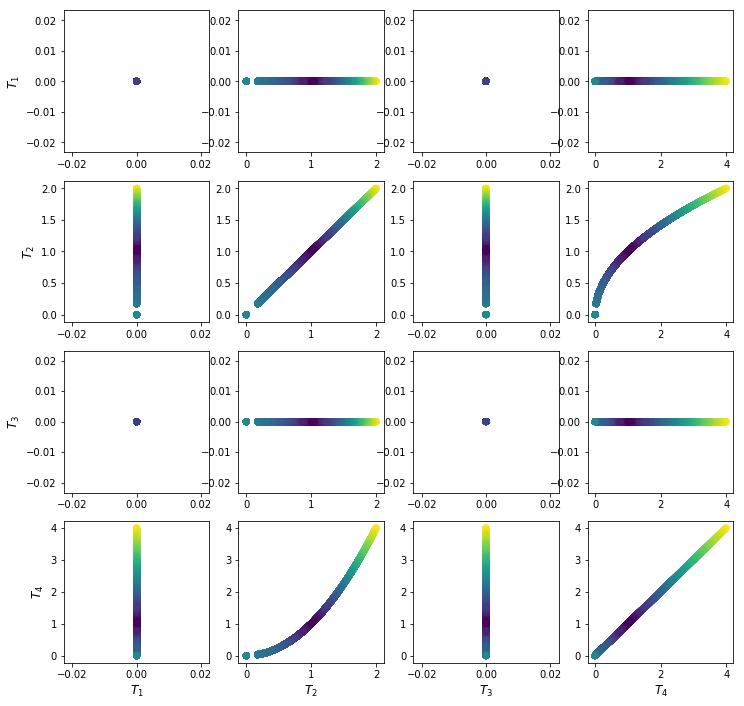

In [11]:
plt.figure(figsize=figsize);
for i in range(system.num_suff_stats):
    for j in range(system.num_suff_stats):
        ind = system.num_suff_stats*i + j + 1;
        plt.subplot(system.num_suff_stats, system.num_suff_stats, ind);
        plt.scatter(_T_a[0,:,j], _T_a[0,:,i], c=distance);
        if (i==3):
            plt.xlabel(r'$T_%d$' % (j+1), fontsize=fontsize);
        if (j==0):
            plt.ylabel(r'$T_%d$' % (i+1), fontsize=fontsize);

plt.show();




In [12]:
print(_T_a.shape)

(1, 59049, 4)
